In [2]:
import os
import random
import matplotlib.pyplot as plt
from utils.data_loader import PatientsRawData

In [3]:
data = PatientsRawData('../data/Исходные файлы/')
data.load_data()

# Data loading

In [4]:
# display different information about the data
print(f' Data labels: {data.Y} for the total of {len(data.X)} data samples coming from patients: {data.patient}')
print('Explore a random data sample: ')
N = random.randint(0,len(data.X))
data.X[N].head()

 Data labels: ['Control', 'Control', 'Control', 'Control', 'Control', 'Control', 'Control', 'Control', 'ET', 'ET', 'ET', 'ET', 'ET', 'ET', 'ET', 'ET', 'ET', 'ET', 'ET', 'ET', 'ET', 'Left', 'Left', 'Left', 'Left', 'Left', 'Left', 'Left', 'Left', 'Left', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right'] for the total of 41 data samples coming from patients: ['аста0101.txt', 'дюки0102.txt', 'керш0103.txt', 'лега0104.txt', 'сидо0105.txt', 'фрол0106.txt', 'хвал0107.txt', 'черк0108.txt', 'даке0101.txt', 'ершо0102.txt', 'кудр0103.txt', 'купр0104.txt', 'куту0105.txt', 'лити0106.txt', 'луче0107.txt', 'макс0108.txt', 'миро0109.txt', 'молю01010.txt', 'муха01011.txt', 'соко01012.txt', 'тихо01013.txt', 'ерми0101.txt', 'кова0102.txt', 'колг0103.txt', 'медв0104.txt', 'наза0105.txt', 'погр0106.txt', 'савв0107.txt', 'сави0108.txt', 'шелу0109.txt', 'бело0101.txt', 'гава0102.txt', 'голу0103.txt', 'грек0104.txt', 'губа0105.txt', 'павл0106.txt', 'пана0107.tx

,FP1,FP2,F3,F4,C3,C4,P3,P4,O1,O2,...,F8,T3,T4,T5,T6,CZ,EMG1,EMG2,EMG3,EMG4
0,2,4,6,18,9,17,7,31,8,24,...,5,7,9,1,2,1,-32,-29,92,-4
1,0,19,-3,-15,14,5,5,6,4,2,...,-30,2,-57,1,-60,1,-43,-7,29,0
2,-17,-19,-19,-47,-8,-43,-15,-45,-13,-43,...,-48,-12,-63,-8,-65,0,-17,-10,-81,2
3,-22,-38,-19,-37,-20,-54,-21,-52,-17,-49,...,-30,-13,-23,-10,-26,1,-11,-13,-28,4
4,-25,-37,-17,-12,-27,-41,-24,-33,-20,-33,...,-5,-13,21,-16,15,-1,-15,-21,38,-1


# Data filtering and processing
## Display a sample of EMG Data

In [5]:
# let's now clean the data to only have EMG data
data.get_emg_data()
data.X[N].head()

,EMG1,EMG2,EMG3,EMG4
0,-32,-29,92,-4
1,-43,-7,29,0
2,-17,-10,-81,2
3,-11,-13,-28,4
4,-15,-21,38,-1


<AxesSubplot:>

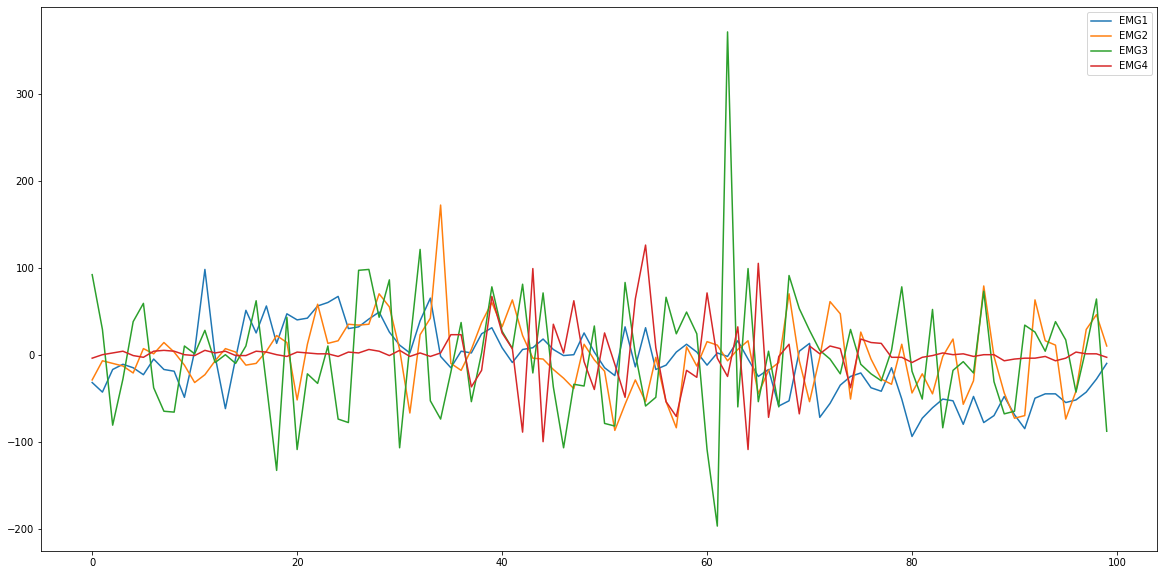

In [6]:
# let's display the original data (first 100  values)
data.X[N][:100].plot(figsize=(20, 10))

## Processing of the EMG data

### Notch filter
A notch filter is a band-stop filter with a narrow bandwidth (high quality factor). It rejects a narrow frequency band and leaves the rest of the spectrum little changed.
Here the implementation from [scipy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.iirnotch.html) is used

In [116]:
from scipy.signal import iirnotch
from scipy import signal

In [117]:
# parameters for filters
frequences_to_filter = [50, 100, 150, 200 ] # frequence of 'setevaya navodka'
SamplingRate  = 500
LF= 60
UF= 240
#HalfRate= SamplingRate / 2 # Найквист fr
#W1= LF / HalfRate # stop frequency/nyq
#W2= UF / HalfRate # corner frequency/nyq
#HalfOrder= 4

In [118]:
def notch_filtering(Frequency,SelectedVector,SamplingRate,Q=35):
    '''remove Frequency from signal'''
    wo= Frequency / (SamplingRate / 2)
    # bw= wo / Q
    # Make order 2 bandstop digital filter
    b, a = signal.iirnotch(wo, Q) 
    notch_filtered=signal.lfilter(b, a, SelectedVector)
    return notch_filtered

###  Butterworth filter
Again taken from [scipy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.butter.html).
Кроме того, для ЭМГ использовался фильтр Баттерворта с полосой пропускания от 60 до 240 Гц. Для АКС использовался фильтр Баттерворта с полосой пропускания от 0,1 до 240 Гц для анализа тремора в диапазоне частот от 0,5 до 4 Гц и с полосой пропускания от 2 до 240 Гц для анализа тремора в диапазоне частот от 4 до 50 Гц.

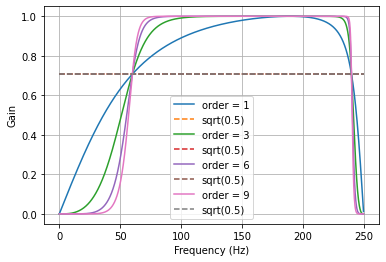

In [119]:
# Plot the frequency response for a few different orders.
from scipy.signal import butter, lfilter

def butter_bandpass(lowcut, highcut, fs, order=5):
    return butter(order, [lowcut, highcut], fs=fs, btype='band')

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y


# Sample rate and desired cutoff frequencies (in Hz).
fs = SamplingRate
lowcut = 60
highcut = 240

# Plot the frequency response for a few different orders.
plt.figure(1)
plt.clf()
for order in [1, 3, 6, 9]:
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    w, h = freqz(b, a, fs=fs, worN=2000)
    plt.plot(w, abs(h), label="order = %d" % order)

    plt.plot([0, 0.5 * fs], [np.sqrt(0.5), np.sqrt(0.5)],
             '--', label='sqrt(0.5)')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Gain')
    plt.grid(True)
    plt.legend(loc='best')
plt.show()

In [120]:
# Take one EMG signal to process
signal_emg = data.X[N]['EMG1'].to_numpy()

Text(0.5, 1.0, 'Magnitude of the signal, fs=500')

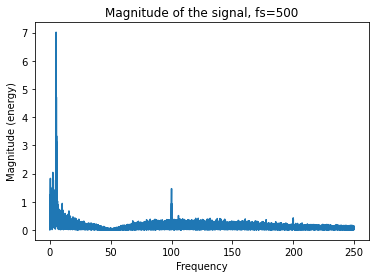

In [121]:
# plot spectrogram of the unprocessed signal
plt.magnitude_spectrum(signal_emg, Fs=SamplingRate)
plt.title('Magnitude of the signal, fs=500')

In [122]:
# Notch filter only, applu
notch_filtered = signal_emg.copy()
for filtered_frequency in frequences_to_filter:
    notch_filtered = notch_filtering(filtered_frequency,notch_filtered,SamplingRate,Q=35)


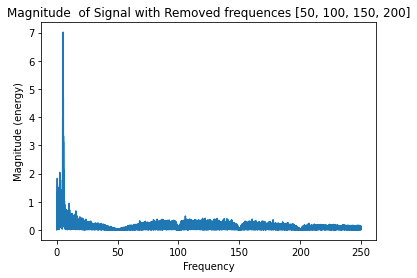

In [113]:
plt.magnitude_spectrum(notch_filtered, Fs=SamplingRate)
plt.title(f'Magnitude  of Signal with Removed frequences {frequences_to_filter}')
plt.show()

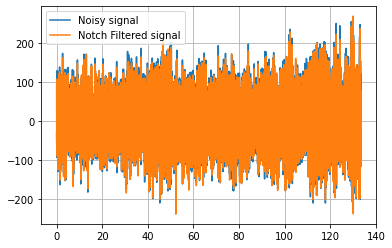

In [107]:
# plot initial signal
t = np.arange(0, len(signal_emg)) /  SamplingRate
plt.figure(2)
plt.clf()
plt.plot(t, signal_emg, label='Noisy signal')
plt.axis('tight')

plt.plot(t, notch_filtered, label='Notch Filtered signal')
plt.grid(True)
plt.axis('tight')
plt.legend(loc='upper left')
plt.show()

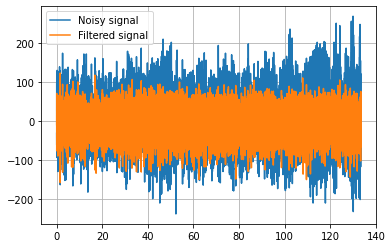

In [110]:
# butterworth filter only
# Filter a noisy signal.
t = np.arange(0, len(signal_emg)) /  SamplingRate
plt.figure(2)
plt.clf()
plt.plot(t, signal_emg, label='Noisy signal')
plt.axis('tight')

y = butter_bandpass_filter(signal_emg, lowcut, highcut, fs, order=4)
plt.plot(t, y, label='Filtered signal')
plt.grid(True)
plt.axis('tight')
plt.legend(loc='upper left')
plt.show()

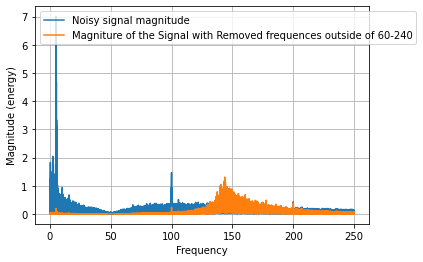

In [123]:
plt.figure(2)
plt.clf()
plt.magnitude_spectrum(signal_emg, Fs=SamplingRate, label='Noisy signal magnitude')
plt.axis('tight')

plt.magnitude_spectrum(butter_filtered, Fs=SamplingRate, label=f'Magniture of the Signal with Removed frequences outside of 60-240')
plt.grid(True)
plt.axis('tight')
plt.legend(loc='upper left')
plt.show()

## Finally, plot the signal which was first notch-filtered and then gone through the butterworth filter

In [124]:
# apply band filter on filtered signal
processed = butter_bandpass_filter(notch_filtered, lowcut, highcut, fs, order=4)

### Display the final results
Show the final sinal, and its spectrogram

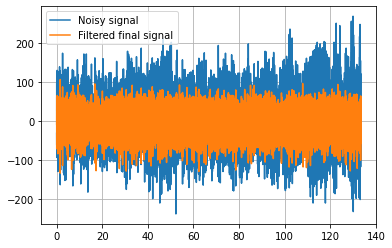

In [101]:
# butterworth filter only
# Filter a noisy signal.
t = np.arange(0, len(signal_emg)) /  SamplingRate
plt.figure(2)
plt.clf()
plt.plot(t, signal_emg, label='Noisy signal')
plt.axis('tight')

plt.plot(t,processed, label='Filtered final signal')
plt.hlines([-a, a], 0, T, linestyles='--')
plt.grid(True)
plt.axis('tight')
plt.legend(loc='upper left')
plt.show()

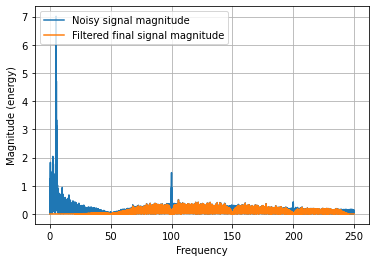

In [125]:
# butterworth filter only
# Filter a noisy signal.
plt.figure(2)
plt.clf()
plt.magnitude_spectrum(signal_emg, Fs=SamplingRate, label='Noisy signal magnitude')
plt.axis('tight')

plt.magnitude_spectrum(processed, Fs=SamplingRate, label='Filtered final signal magnitude')
plt.grid(True)
plt.axis('tight')
plt.legend(loc='upper left')
plt.show()

Visually, it looks like the newly processed signal is correct.
Maybe the butterworth filter degree should be higher to remove all the frequences below 60?